# Tocantins sample data set from PUC-rio

#### Import libraries

In [1]:
%matplotlib inline
from IPython.display import Markdown as md
from IPython.display import display as dp
import string as st
import sys
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import datetime

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from fatiando.utils import ang2vec, vec2ang
from fatiando.mesher import Sphere, Prism, PolygonalPrism, PrismMesh
from fatiando.gravmag import sphere, prism, polyprism
from fatiando.gridder import regular

/home/andrelreis/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
notebook_name = 'tocantins_data_eqlayer.ipynb'

### Plot style

In [3]:
plt.style.use('ggplot')

#### Importing auxiliary functions

In [4]:
dir_modules = '../'
sys.path.append(dir_modules)

In [5]:
import my_package as fc

## Loading data 

In [6]:
with open('data/data_set.pickle') as f:
        data = pickle.load(f)

## Loading regular grid

In [7]:
with open('data/regular_grid.pickle') as f:
        grid = pickle.load(f)

### Open a dictionary

In [8]:
inversion = dict()

#### List of saved files

In [9]:
saved_files = []

### Parameters of acquisition

In [10]:
print 'Shape : (%.0f,%.0f)'% grid['shape'] 
print 'Number of data: %.1f' % grid['N']
print 'dx: %.1f $\mu m$' % grid['dx']
print 'dy: %.1f $\mu m$ ' % grid['dy']
print 'Height: %.1f $\mu m$' % grid['z_obs']

Shape : (128,70)
Number of data: 8960.0
dx: 270.1 $\mu m$
dy: 271.0 $\mu m$ 
Height: -1308.0 $\mu m$


In [11]:
xp,yp,zp = grid['x'],grid['y'],grid['z']

In [12]:
Y = yp.reshape(grid['shape'])
X = xp.reshape(grid['shape'])

## Generating an equivalent layer

In [13]:
inc,dec = 90.,0.

In [14]:
zc = -633.

In [15]:
xs,ys,zs = regular(grid['area'],grid['shape'],zc)

In [16]:
data_obs = data['obs_decimated'].ravel()

In [17]:
G_z = fc.sensitivity_bz(xp,yp,zp,xs,ys,zs,inc,dec)

In [18]:
mu = [1e-17,1e-16,1e-15,1e-12,1e-11,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4]
I = np.identity(grid['Nx']*grid['Ny'])

In [19]:
r_norm = []
p_norm = []
parameter = []
for m in mu:
    print m
    p = np.linalg.solve(np.dot(G_z.T,G_z) + m*I,np.dot(G_z.T,data_obs))
    data_pred = fc.bz_layer(xp,yp,zp,xs,ys,zs,p,inc,dec)
    r = data_obs - data_pred
    
    r_norm.append(np.linalg.norm(r))
    p_norm.append(np.linalg.norm(p))
    parameter.append(p)

1e-17
1e-16
1e-15
1e-12
1e-11
1e-09
1e-08
1e-07
1e-06
1e-05
0.0001


### L-curve

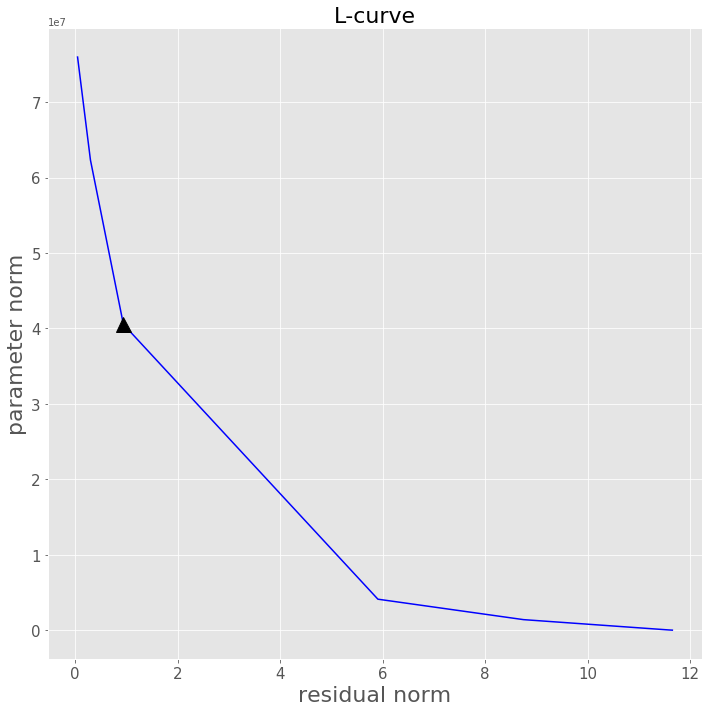

In [25]:
title_font = 22
bottom_font = 20
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(10,10), tight_layout=True)

plt.plot(r_norm,p_norm, 'b-')
plt.plot(r_norm[2],p_norm[2], 'k^',markersize=15)
plt.title('L-curve', fontsize=title_font)
plt.xlabel('residual norm', fontsize = title_font)
plt.ylabel('parameter norm', fontsize = title_font)
plt.tick_params(axis='both', which='major', labelsize=15)

file_name = 'figs/Lcurve_RM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

#plt.savefig(file_name+'.eps',dpi=300)
#saved_files.append(file_name+'.eps')


plt.show()

### Results 

In [21]:
inversion['mu'] = mu
inversion['parameter'] = parameter
inversion['p_norm'] = p_norm
inversion['r_norm'] = r_norm
inversion['zc'] = zc
inversion['inc_l'] = inc
inversion['dec_l'] = dec

#### Generating .pickle file

In [22]:
now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
inversion['metadata'] = 'Generated by {name} on {date}'.format(date=now, name=notebook_name)

In [23]:
file_name = 'data/inversion.pickle'
with open(file_name, 'w') as f:
    pickle.dump(inversion, f)
    
saved_files.append(file_name)

In [24]:
with open('reports/report_%s.md' % notebook_name[:st.index(notebook_name, '.')], 'w') as q:
    q.write('# Saved files \n')
    now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
    header = 'Generated by {name} on {date}'.format(date=now, name=notebook_name)
    q.write('\n\n'+header+'\n\n')
    for i, sf in enumerate(saved_files):
        print '%d  %s' % (i+1,sf)
        q.write('*  `%s` \n' % (sf))

1  figs/Lcurve_RM.png
2  data/inversion.pickle
